In [73]:
import numpy as np
from pathlib import Path

# Path to the logs directory
logs_dir = Path("/Users/jare/Documents/Personal projects/Pendulum NN/pendulum-nn/logs")

# Find all .npz files in the logs directory
log_files = sorted(logs_dir.glob("*.npz"))

# Initialize a list to store segments
raw_segments = []

# Load each .npz file and store its data as a separate segment
for log_file in log_files:
    data = np.load(log_file)
    peaks = data["peaks"]
    timestamps_ms = data["timestamps_ms"]
    raw_segments.append({"peaks": peaks, "timestamps_ms": timestamps_ms})
    #print(f"Loaded {len(peaks)} entries from {log_file.name}")

# Display the total number of segments and a preview of the first segment
print(f"Total number of segments: {len(raw_segments)}")

print(f"First segment preview: {raw_segments[0]}")

Total number of segments: 401
First segment preview: {'peaks': array([-1373,   535, -1275,   444, -1187,   364, -1112,   295, -1047,
         234,  -990,   178,  -937,   126,  -886,    80,  -843,    40,
        -804,     4,  -771,   -27,  -743,   -52,  -719,   -74,  -697,
         -94,  -677,  -113,  -660,  -129,  -643,  -145,  -628,  -159,
        -615,  -172,  -602], dtype=int32), 'timestamps_ms': array([26, 18, 25, 24, 23, 12, 20, 11, 21, 19,  9, 10, 12, 28, 34, 26, 23,
        6, 10, 29, 25, 24, 22, 36, 27, 30, 32, 18, 41, 37, 10, 10, 36, 40,
       40, 41, 26, 46, 41])}


In [74]:
#Average of all peaks across segments
all_raw_peaks = np.concatenate([segment["peaks"] for segment in raw_segments])
average_peak = np.mean(all_raw_peaks)
print(f"Total number of peaks across all segments: {len(all_raw_peaks)}")
print(f"Average peak value across all segments: {average_peak}")

baseline = round(average_peak)

all_adjusted_peaks = [x - baseline for x in all_raw_peaks]

Total number of peaks across all segments: 12319
Average peak value across all segments: -381.2010715155451


In [75]:
# Create adjusted_segments by applying the baseline to each entry in ["peaks"]
adjusted_segments = []
for segment in raw_segments:
    adjusted_segment = {
        "peaks": segment["peaks"] - baseline,
        "timestamps_ms": segment["timestamps_ms"]
    }
    adjusted_segments.append(adjusted_segment)

# Preview the first adjusted segment
print(f"Baseline: {baseline}")
print(f"First adjusted segment peaks: {adjusted_segments[0]['peaks'][:10]}")
print(f"First adjusted segment timestamps: {adjusted_segments[0]['timestamps_ms'][:10]}")

Baseline: -381
First adjusted segment peaks: [-992  916 -894  825 -806  745 -731  676 -666  615]
First adjusted segment timestamps: [26 18 25 24 23 12 20 11 21 19]


## Distributions

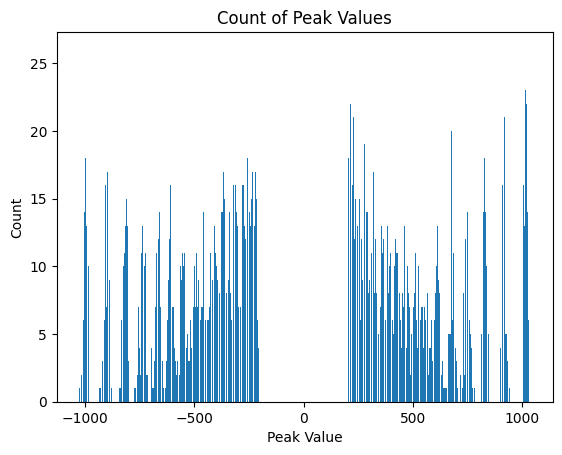

In [76]:
# Get count of unique adjusted peak values
unique, counts = np.unique(all_adjusted_peaks, return_counts=True)
peak_distribution = dict(zip(unique, counts))

#Plot bar chart of adjusted peaks
import matplotlib.pyplot as plt

plt.bar(unique, counts)
plt.xlabel("Peak Value")
plt.ylabel("Count")
plt.title("Count of Peak Values")
plt.show()

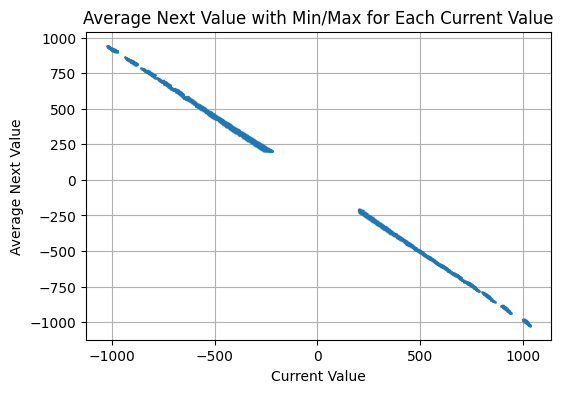

In [77]:
# Iterate through each adjusted segment and create a transition dictionary
transition_dict = {}
for segment in adjusted_segments:
    peaks = segment["peaks"]
    for i in range(len(peaks) - 1):
        current_value = peaks[i]
        next_value = peaks[i + 1]
        if current_value not in transition_dict:
            transition_dict[current_value] = []
        transition_dict[current_value].append(next_value)

# Calculate the max, min, avg, and count of each transition
transition_stats = {}
for key, values in transition_dict.items():
    transition_stats[key] = {
        "max": np.max(values),
        "min": np.min(values),
        "avg": np.mean(values),
        "count": len(values)
    }

# Plot a scatterplot of the average values with error bars for min and max
plt.figure(figsize=(6, 4))

# Extract data for plotting
keys = list(transition_stats.keys())
avg_values = [stats["avg"] for stats in transition_stats.values()]
min_values = [stats["min"] for stats in transition_stats.values()]
max_values = [stats["max"] for stats in transition_stats.values()]

# Calculate error bars (distance from avg to min and avg to max)
yerr = [
    [avg - min_val for avg, min_val in zip(avg_values, min_values)],  # Lower error
    [max_val - avg for avg, max_val in zip(avg_values, max_values)]   # Upper error
]

# Create scatterplot with error bars 
# Adjust marker size
plt.errorbar(keys, avg_values, yerr=yerr, fmt='o', label="Avg with Min/Max", alpha=0.7, capsize=1, markersize=1)

# Add labels and title
plt.xlabel("Current Value")
plt.ylabel("Average Next Value")
plt.title("Average Next Value with Min/Max for Each Current Value")
plt.grid(True)
plt.show()

In [78]:
#Examine a single transition
transition_to_examine = 810  # Example peak value to examine
if transition_to_examine in transition_dict:
    next_values = transition_dict[transition_to_examine]
    print(f"Transition statistics for peak value {transition_to_examine}:")
    print(f"Count: {len(next_values)}")
    print(f"Max: {np.max(next_values)}")
    print(f"Min: {np.min(next_values)}")
    print(f"Avg: {np.mean(next_values)}")
else:
    print(f"No transitions found for peak value {transition_to_examine}.")

Transition statistics for peak value 810:
Count: 1
Max: -797
Min: -797
Avg: -797.0


## Time spent at peaks

In [79]:
time_at_peaks = {}
for segment in adjusted_segments:
    peaks = segment["peaks"]
    timestamps = segment["timestamps_ms"]
    for peak, timestamp in zip(peaks, timestamps):
        if peak not in time_at_peaks:
            time_at_peaks[peak] = []
        time_at_peaks[peak].append(int(timestamp))
        
# Preview time_at_peaks for a few peak values
for peak in list(time_at_peaks.keys())[:5]:
    print(f"Peak Value: {peak}, Timestamps (ms): {time_at_peaks[peak][:10]}")

Peak Value: -992, Timestamps (ms): [26, 11, 18, 23, 14, 19, 21, 25, 17, 20]
Peak Value: 916, Timestamps (ms): [18, 26, 19, 7, 24, 24, 27, 26, 25, 19]
Peak Value: -894, Timestamps (ms): [25, 24, 23, 14, 20, 25, 23, 5, 8, 17]
Peak Value: 825, Timestamps (ms): [24, 20, 7, 13, 13, 20, 23, 20, 12, 29]
Peak Value: -806, Timestamps (ms): [23, 23, 27, 24, 18, 17, 12, 20, 21, 17]


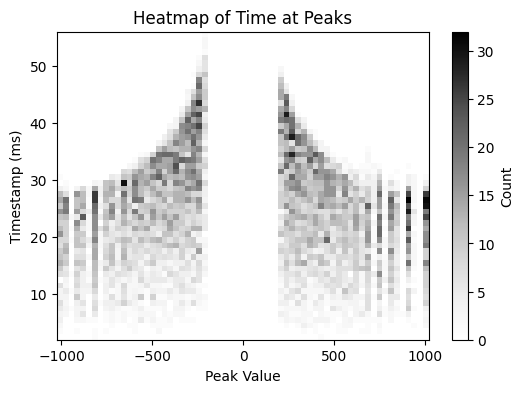

In [89]:
import matplotlib.pyplot as plt
import numpy as np

# Flatten the time_at_peaks data into x (peaks) and y (timestamps)
x = []
y = []
for peak, timestamps in time_at_peaks.items():
    x.extend([peak] * len(timestamps))  # Repeat the peak value for each timestamp
    y.extend(timestamps)               # Add all corresponding timestamps

# Define the bins for the heatmap
x_bins = np.arange(min(x), max(x) + 1, 32)  # One bin per peak value
y_bins = np.arange(min(y), max(y) + 1, 1)  # One bin per timestamp value

# Create a 2D histogram
plt.figure(figsize=(6, 4))
heatmap, xedges, yedges, _ = plt.hist2d(x, y, bins=[x_bins, y_bins], cmap="Greys")

# Add colorbar and labels
plt.colorbar(label="Count")
plt.xlabel("Peak Value")
plt.ylabel("Timestamp (ms)")
plt.title("Heatmap of Time at Peaks")
plt.show()